In [20]:
import numpy as np
import joblib
import scipy.io as sio
import pandas as pd

import xarray
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.dates as mpd

from sklearn.linear_model import LinearRegression
# from brainscore.metrics.regression import pearsonr
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import os


from brainio_base.assemblies import NeuronRecordingAssembly
import brainscore

from scipy import signal, interpolate
from scipy.signal import find_peaks, find_peaks_cwt

def apply_bandpass(data, fs, flow, fhigh):
    wl = flow / (fs / 2.)
    wh = fhigh / (fs / 2.)
    wn = [wl, wh]

    # Designs a 2nd-order Elliptic band-pass filter which passes
    # frequencies between 0.03 and 0.6, an with 0.1 dB of ripple
    # in the passband, and 40 dB of attenuation in the stopband.
    # The question is, do we really want to use IIR filter design?
    # Isn't it the case that IIR filters introduce refractory period
    # artifacts, and thus FIRs are preferred in practice?
    b, a = signal.ellip(2, 0.1, 40, wn, 'bandpass', analog=False)
    # To match Matlab output, we change default padlen from
    # 3*(max(len(a), len(b))) to 3*(max(len(a), len(b)) - 1)
    return signal.filtfilt(b, a, data, padlen=3*(max(len(a),len(b))-1))


def moving_average(x, w):
    w = int(w)
    return np.convolve(x, np.ones(w), 'same')

import configparser


config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('../spike_tools/spike_config.ini')


from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
all_dates = ['210209', '210225', '210322', '210325', '210406', '210423',
       '210510', '210524', '210602', '210716', '210720', '210721',
       '210722', '210723', '210724', '210803', '210813', '210825',
       '210920', '210923', '211001', '211005', '211115', '211116']

In [21]:
all_dates = ['211115', '211116', '211206', '220124', '220127']

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211115_123406/oleo_normalizers-pIT_211115_123406_psth.mat
[48 39 37 23  7  0  6 32 14 30 47 24 19  3 40 28 41 29 34 17 21 36 38 18
 22 43  5 31 27 45 12  2  8 46  4 33 26 13 11  1 25 16 44 15 42 20 35  9
 10]


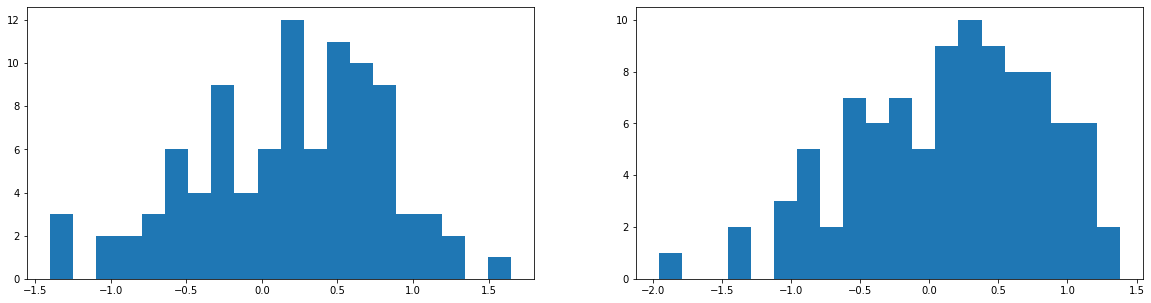

211115 0 0
/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211116_124142/oleo_normalizers-pIT_211116_124142_psth_base.mat
[48 39 37 23  7  0  6 32 14 30 47 24 19  3 40 28 41 29 34 17 21 36 38 18
 22 43  5 31 27 45 12  2  8 46  4 33 26 13 11  1 25 16 44 15 42 20 35  9
 10]


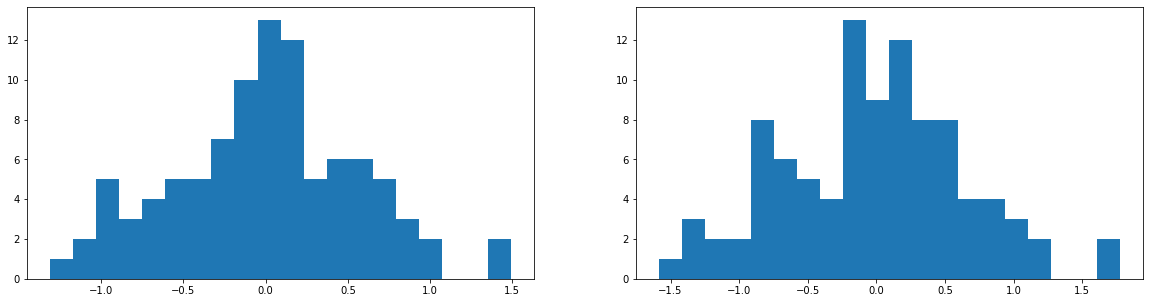

211116 0 0
/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220124_122758/oleo_normalizers-pIT_220124_122758_psth.mat
[49 40 38 23  7  0  6 34 14 31 48 24 19  3 41 28 43 30 47 17 21 29 39 18
 22 44 37  5 32 27 46 12  2  8 36  4 33 26 13 11  1 25 16 45 15 42 20 35
  9 10]


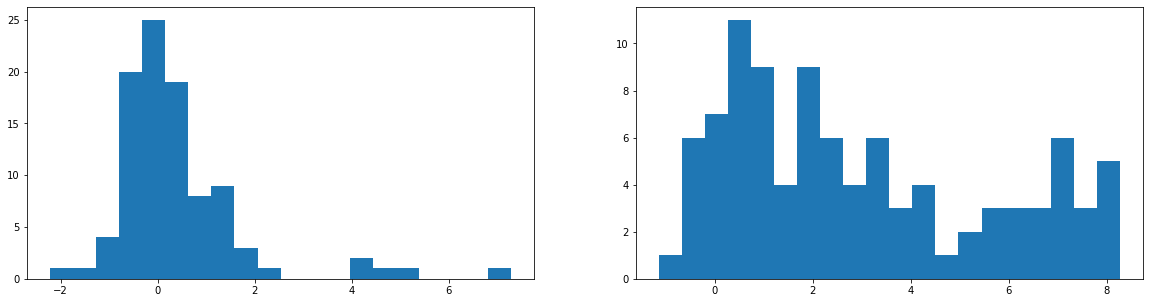

220124 6 50
/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/oleo_normalizers-pIT_220127_141756_psth_base.mat
[49 40 38 23  7  0  6 34 14 31 48 24 19  3 41 28 43 30 47 17 21 29 39 18
 22 44 37  5 32 27 46 12  2  8 36  4 33 26 13 11  1 25 16 45 15 42 20 35
  9 10]


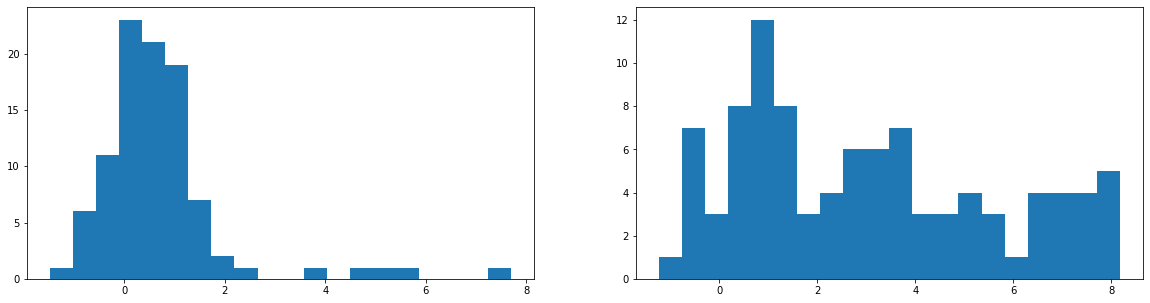

220127 6 54


In [22]:
config['Experiment Information']['name'] = 'normalizers-pIT'

analysis_conditions = ['base', 'salpa', 'wosalpa', 'woartefacts', 'thres4', 
                               'bin5', 'bin2', 'salpabin5', 'salpabin2', 
                               'absthres40', 'absthres40bin5', 'absthres40bin2', 'absthres30']

timebin_sizes = {'base':10,'salpa':10, 'wosalpa':10, 'woartefacts':10, 'thres4':10, 'bin5':5, 
                         'bin2':2, 'salpabin5':5, 'salpabin2':2,  
                         'absthres40':10, 'absthres40bin5':5, 'absthres40bin2':2, 'absthres30':10}

dataPath = "/braintree/data2/active/users/ssazaidi/projects/"+config['Experiment Information']['name']+"/monkeys/oleo/"

procDataPath = dataPath+'intanproc'
cond_num = 0

channel_consistency_across_time = joblib.load('channel_consistency_across_time.pkl')


for date in all_dates:

    


    ### Load MWORKS DATA ###

#     mworksDirproc = '../../projects/'+config['Experiment Information']['name']+'/monkeys/oleo/mworksproc/'
    # mworksFilename = [i for i in os.listdir(mworksDirproc) if date in i][0]
    # data_info = pd.read_csv(os.path.join(mworksDirproc, mworksFilename))
    # samp_on_id = data_info.stim_id.values
    # samp_on_current = data_info.stim_current.values
    
    if date in channel_consistency_across_time and not (date in ['211115', '211116'] ):
        continue

    directory_path = os.path.join(procDataPath,[i for i in os.listdir(procDataPath) if date in i][0])

    filenames = [os.path.join(directory_path, i) for i in os.listdir(directory_path) if date in i]



    analysis_condition = '_'+analysis_conditions[cond_num]
    timebin_size = timebin_sizes[analysis_conditions[cond_num]]
#     filename = [i for i in filenames if analysis_condition in i][0]
    filename = filenames[0]
    print(filename)

    psth = sio.loadmat(filename)

    psth_data = psth['psth']

    stim_wise_psth = []
    for i in range(psth_data.shape[0]):
        temp = psth_data[i,...]
        include_idx = np.unique(np.where(np.logical_not (np.isnan(temp)))[0])
        temp = temp[include_idx, ...]
        stim_wise_psth.append(temp)

    stim_wise_psth = [i for i in stim_wise_psth if i.shape[0] > 0]
    min_reps = np.min([i.shape[0] for i in stim_wise_psth])

    re_psth_data = np.zeros([len(stim_wise_psth), min_reps, stim_wise_psth[0].shape[1],stim_wise_psth[0].shape[-1]])

    for i, stim_psth in enumerate(stim_wise_psth):
        re_psth_data[i,...] = stim_wise_psth[i][:min_reps,...]

    ## PRESENTATIONS ##
    shuffle_flag = True

    shuffled_idcs = np.arange(re_psth_data.shape[1])
    if shuffle_flag:
        np.random.seed(6)
        np.random.shuffle(shuffled_idcs)
    print(shuffled_idcs)

    re_psth_data = re_psth_data[:,shuffled_idcs,...]

    ## IDS ##

    shuffle_flag = False

    shuffled_idcs = np.arange(re_psth_data.shape[0])
    if shuffle_flag:
        np.random.seed(1)
        np.random.shuffle(shuffled_idcs)

    psth_data_1 = re_psth_data[:,:int(min_reps/2),...]
    psth_data_2 = re_psth_data[shuffled_idcs,int(min_reps/2):,...]

    cIT_trial_average_binwise_a = np.mean(psth_data_1[...,96:192], axis=1)
    aIT_trial_average_binwise_a = np.mean(psth_data_1[...,:96], axis=1)
    cIT_trial_average_binwise_b = np.mean(psth_data_2[...,96:192], axis=1)
    aIT_trial_average_binwise_b = np.mean(psth_data_2[...,:96], axis=1)


    cIT_trial_dev_binwise_a = np.std(psth_data_1[...,96:192], axis=1)
    aIT_trial_dev_binwise_a = np.std(psth_data_1[...,:96], axis=1)
    cIT_trial_dev_binwise_b = np.std(psth_data_2[...,96:192], axis=1)
    aIT_trial_dev_binwise_b = np.std(psth_data_2[...,:96], axis=1)

    cIT_trial_average_shape = cIT_trial_average_binwise_a.shape
    aIT_trial_average_shape = aIT_trial_average_binwise_a.shape

    cIT_r2 = np.zeros(cIT_trial_average_binwise_a.shape[1:])
    aIT_r2 = np.zeros(aIT_trial_average_binwise_a.shape[1:])
    for i in range(cIT_trial_average_binwise_a.shape[1]):
        for j in range(cIT_trial_average_binwise_a.shape[2]):
            cIT_r2[i,j] = np.array(pearsonr(cIT_trial_average_binwise_a[:,i,j],cIT_trial_average_binwise_b[:,i,j]))[0]
            aIT_r2[i,j] = np.array(pearsonr(aIT_trial_average_binwise_a[:,i,j],aIT_trial_average_binwise_b[:,i,j]))[0]

    ## Good Channel Detection

    aIT_r2_sum = np.sum((aIT_r2)[17:27, :], axis=0)
    cIT_r2_sum = np.sum((cIT_r2)[17:27, :], axis=0)
    fig = plt.figure(figsize= [20,5])

    plt.subplot(1,2,1)
    plt.hist(cIT_r2_sum, 20)

    plt.subplot(1,2,2)
    plt.hist(aIT_r2_sum, 20)
    plt.show()
    plt.close()
    # channel_consistency_across_time = {}

    channel_consistency_across_time[date] = {'cIT':aIT_r2_sum, 'aIT':cIT_r2_sum}

    joblib.dump(channel_consistency_across_time, 'channel_consistency_across_time.pkl')

    good_cIT = np.where(cIT_r2_sum > 2)
    good_aIT = np.where(aIT_r2_sum > 2)

    print(date, len(good_cIT[0]),len(good_aIT[0]))

In [23]:
[os.path.join(directory_path, i) for i in os.listdir(directory_path) ]

['/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/spikeTime',
 '/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/psth',
 '/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/oleo_normalizers-pIT_220127_141756_psth_base.mat',
 '/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/oleo_normalizers-pIT_220127_141756_psth.mat']

## Plot Good Channels across days

In [24]:
procDataPath

'/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc'

In [25]:
# dates = np.array([str(i) for i in np.sort([int(i) for i in channel_consistency_across_time.keys()])])
dates = all_dates

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


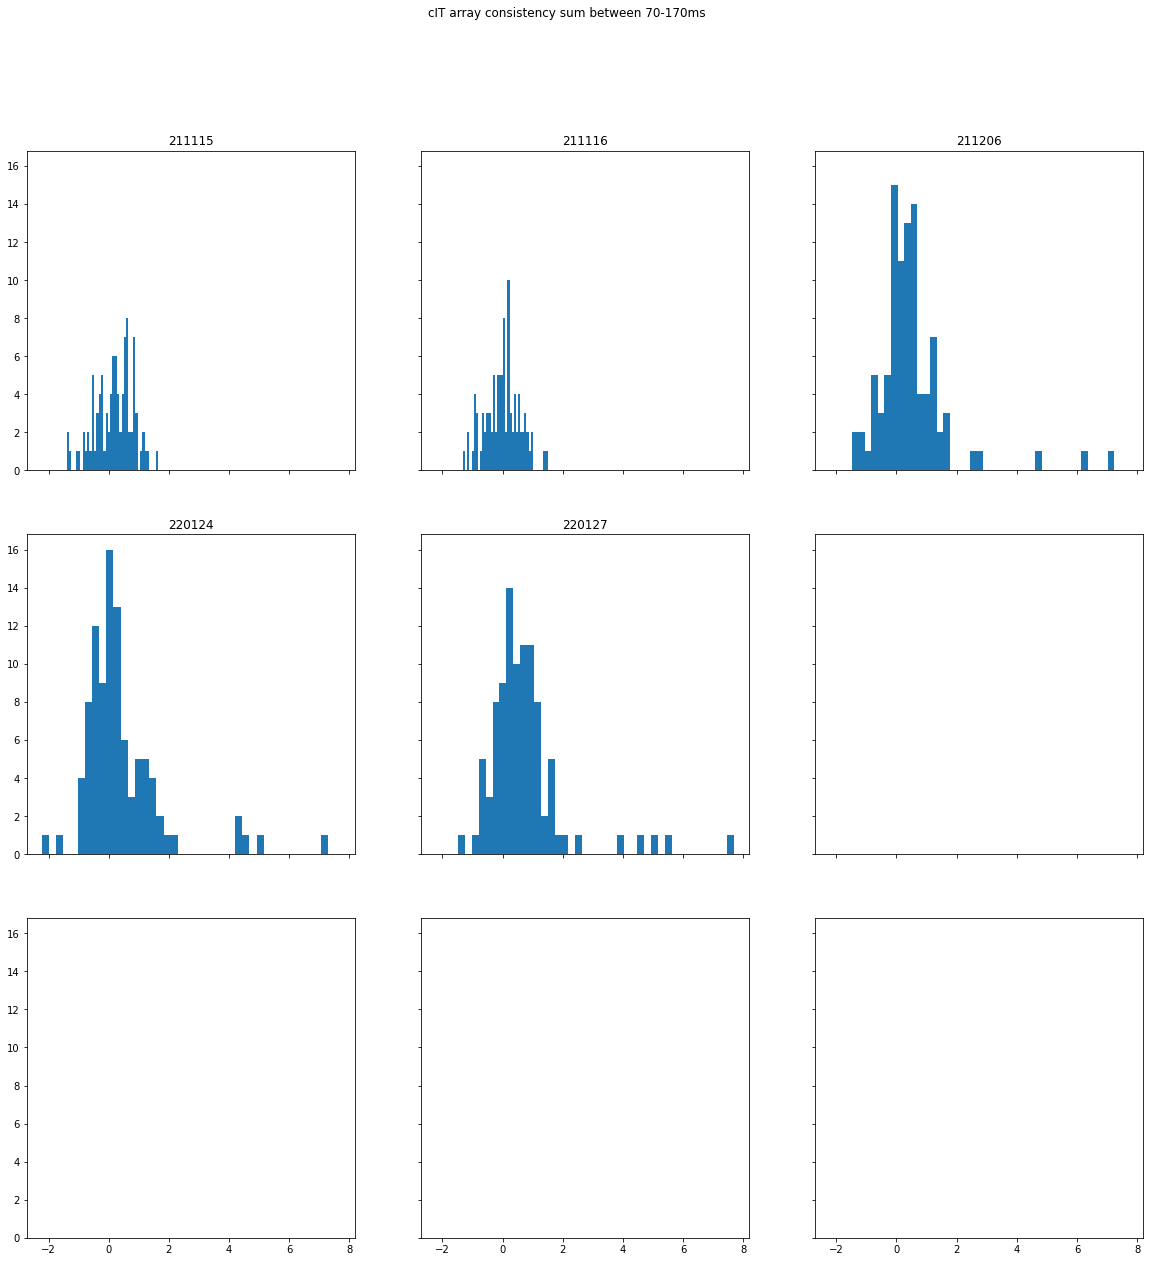

In [26]:
reliable_channel_count_cIT = []
grid_size = np.ceil(np.sqrt(len(dates))).astype(int)
axs = plt.subplots(grid_size, grid_size, sharex=True, sharey=True,figsize=[20,20])
print(axs[1][1])
for i, d in enumerate(dates):
    plt.subplot(grid_size,grid_size,i+1)
    h = plt.hist(channel_consistency_across_time[d]['aIT'], 40)
    reliable_channel_count_cIT.append(np.sum(channel_consistency_across_time[d]['aIT'] > 2))
    plt.title(d)

    
plt.suptitle('cIT array consistency sum between 70-170ms')
plt.show()
plt.close()

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


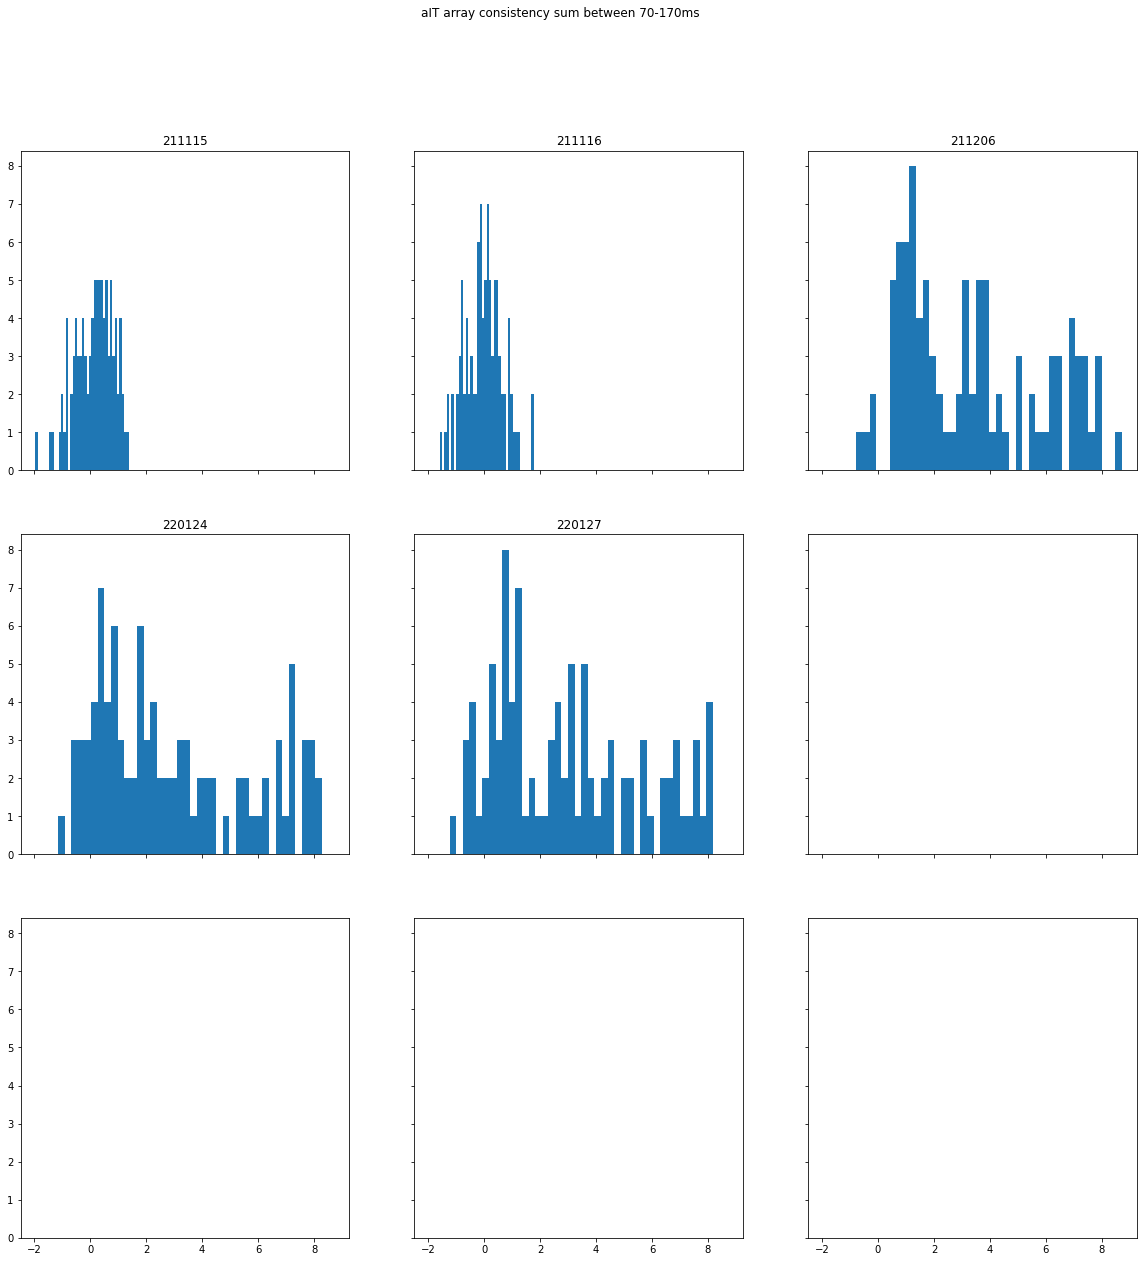

In [27]:
reliable_channel_count_aIT = []
grid_size = np.ceil(np.sqrt(len(dates))).astype(int)
axs = plt.subplots(grid_size, grid_size, sharex=True, sharey=True,figsize=[20,20])
print(axs[1][1])
for i, d in enumerate(dates):
    plt.subplot(grid_size,grid_size,i+1)
    h = plt.hist(channel_consistency_across_time[d]['cIT'], 40)
    reliable_channel_count_aIT.append(np.sum(channel_consistency_across_time[d]['cIT'] > 2))
    plt.title(d)

    
plt.suptitle('aIT array consistency sum between 70-170ms')
plt.show()
plt.close()

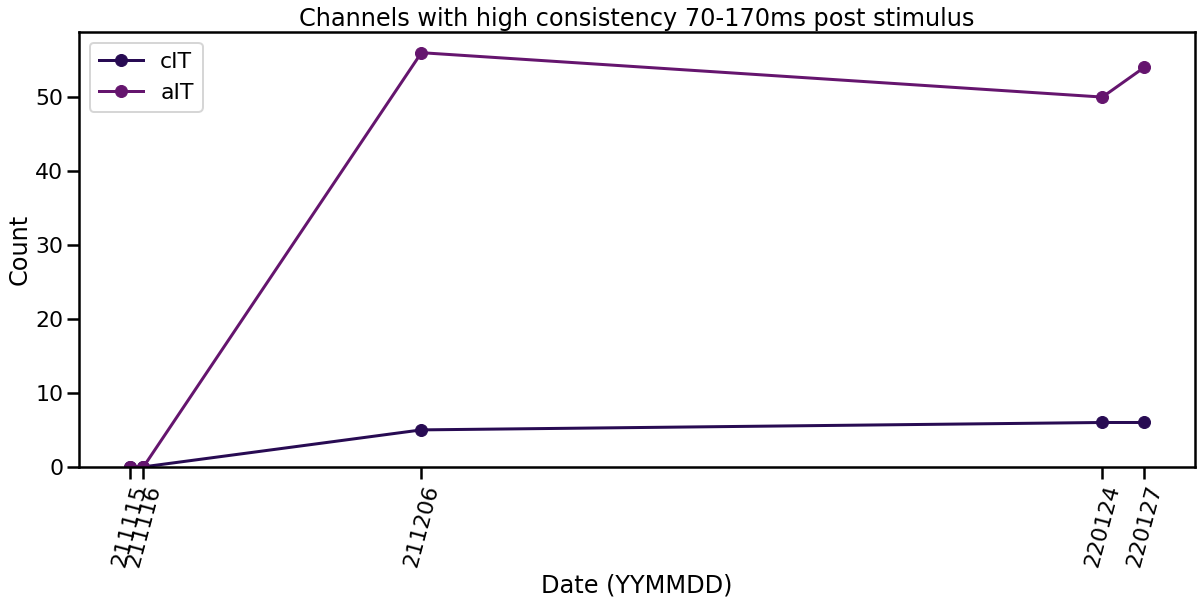

In [28]:
sns.set_context('poster')
sns.set_palette('inferno') 
fig = plt.figure(figsize = [20,8] )
plt.plot(mpd.datestr2num(['20'+i for i in  dates]), reliable_channel_count_cIT, 'o-', label='cIT')
plt.plot(mpd.datestr2num(['20'+i for i in  dates]), reliable_channel_count_aIT, 'o-', label='aIT')
# plt.xticks([int(i) for i in cIT_count.keys()], rotation = 75) 
plt.gca().set_ylim(bottom=0)
plt.xticks(mpd.datestr2num(['20'+i for i in  dates]),dates, rotation = 75)
locator = mpd.AutoDateLocator(interval_multiples=False)
# ax.xaxis.set_major_locator(locator)

plt.xlabel('Date (YYMMDD)')
plt.ylabel('Count')
plt.title('Channels with high consistency 70-170ms post stimulus')
plt.legend()

# plt.savefig('Figures/consistent_channels_over_time_sum.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

In [22]:
, np.where(channel_consistency_across_time[date]['aIT'] > 2)

("np.where(channel_consistency_across_time[date]['aIT']", '>', '2)')

## Plots

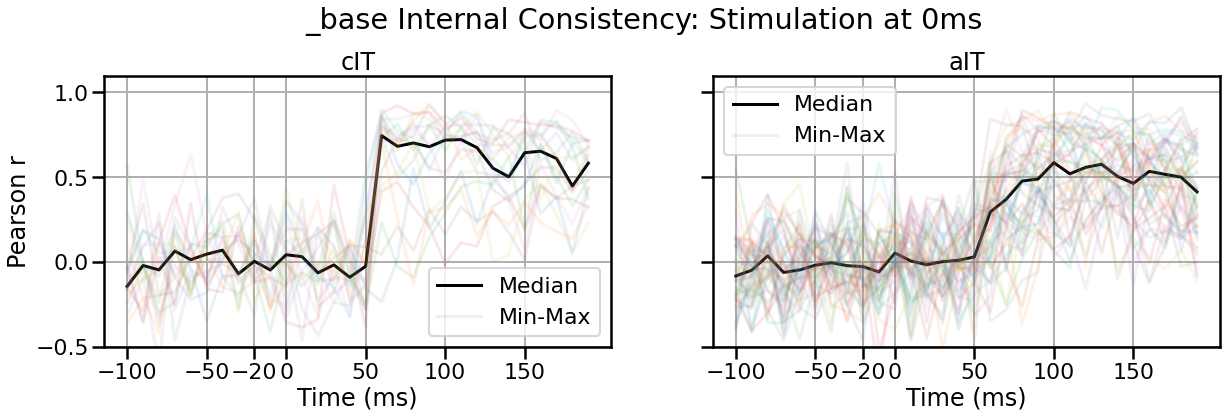

In [558]:
sns.set_context('poster')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)
t = np.arange(cIT_r2.shape[0])*timebin_size - 100
# plt.subplot(1,2,1)
ax = axes[0]
im = ax.plot(t, np.nanmedian(cIT_r2[:,np.where(channel_consistency_across_time[date]['aIT'] > 2)[0]],1), 'k')
ax.grid(True)
# ax.fill_between(t, np.min(cIT_r2,1), np.max(cIT_r2,1), alpha=0.1)
ax.plot(t,cIT_r2[:, np.where(channel_consistency_across_time[date]['aIT'] > 2)[0]], alpha=0.1)
# plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
ax.set_xticks(np.append(np.arange(-100,200,50), [-20]))
ax.set_xlabel('Time (ms)')
ax.set_title('cIT')
ax.set_ylabel('Pearson r')
# plt.xticks(np.arange(-100,200,40))
ax.legend(['Median', 'Min-Max'])
ax.set_ylim([-0.5, 1.1])

######### ignore negative r2 scores #########

# im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(cIT_r2,0),1), 'k')
# ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(cIT_r2,0),1), np.max(np.maximum(cIT_r2,0),1), alpha=0.
# im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(aIT_r2,0),1), 'k', label='Median')
# ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(aIT_r2,0),1), np.max(np.maximum(aIT_r2,0),1), alpha=0.1)

#############################################

ax = axes[1]


im = ax.plot(t, np.nanmedian(aIT_r2[:,np.where(channel_consistency_across_time[date]['cIT'] > 2)[0]],1), 'k', label='Median')
# ax.fill_between(t, np.min(aIT_r2,1), np.max(aIT_r2,1), alpha=0.1)
ax.plot(t,aIT_r2[:,np.where(channel_consistency_across_time[date]['cIT'] > 2)[0]], alpha=0.1)
# plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
ax.set_xlabel('Time (ms)')

# ax.set_ylabel('r2 score')
ax.set_title('aIT')
ax.legend(['Median', 'Min-Max'])
plt.grid(True)
plt.xticks(np.append(np.arange(-100,200,50), [-20]))


fig_path = os.path.join('Figures/',date, analysis_condition[1:])
os.makedirs(fig_path, exist_ok=True)


if shuffle_flag:
    plt.suptitle(analysis_condition+' Internal Consistency Scrambled: Stimulation at 0ms', y= 1.07)
    plt.savefig(os.path.join(fig_path,'Internal_consistency_Scrambled'+analysis_condition+'_'+date+'.jpg'), dpi=300, bbox_inches='tight')
else:
    plt.suptitle(analysis_condition+' Internal Consistency: Stimulation at 0ms', y= 1.07)
    plt.savefig(os.path.join(fig_path,'Internal_consistency'+analysis_condition+'_'+date+'.jpg'), dpi=300, bbox_inches='tight')

In [412]:
# # legends = samp_on_id[:18]+', ' +samp_on_current[:18].astype(str)+'uA'

# f = plt.figure(figsize=[30,12])
# print(aIT_trial_average_binwise_a.shape)
# t = np.arange(cIT_r2.shape[0])*timebin_size - 100
# stim_number = 1

# plt.subplot(2,2,3)
# # temp_mean = aIT_trial_average_binwise_a[stim_number,:,54]
# # temp_dev = aIT_trial_dev_binwise_a[stim_number,:,54]
# temp = np.mean(aIT_trial_average_binwise_a, axis=2)
# # temp = np.mean(temp, axis=1)
# plt.plot(t, temp.T, '-');
# # plt.errorbar(t, temp_mean.T[:30], temp_dev.T[:30]);
# plt.xlabel('Time (ms)')
# plt.ylabel('Average across aIT')
# plt.grid(True)
# # plt.ylim([0,4])



# plt.subplot(2,2,4)
# # temp_mean = aIT_trial_average_binwise_b[stim_number,:,54]
# # temp_dev = aIT_trial_dev_binwise_b[stim_number,:,54]
# temp = np.mean(aIT_trial_average_binwise_b, axis=2)
# # temp = np.mean(temp, axis=1)
# plt.plot(t, temp.T, '-');
# # plt.errorbar(t, temp_mean.T[:30], temp_dev.T[:30]);
# plt.xlabel('Time (ms)')
# # plt.ylabel('# spikes/\n10ms bins')
# plt.grid(True)
# # plt.ylim([0,4])



# plt.subplot(2,2,1)
# # temp_mean = cIT_trial_average_binwise_a[stim_number,:,54]
# # temp_dev = cIT_trial_dev_binwise_a[stim_number,:,54]
# temp = np.mean(cIT_trial_average_binwise_a, axis=2)
# # temp = np.mean(temp, axis=1)
# plt.plot(t, temp.T, '-');
# # plt.errorbar(t, temp_mean.T[:30], temp_dev.T[:30]);
# # plt.xlabel('time (ms)')
# plt.ylabel('Average across cIT')
# plt.title('Split Half 1')
# plt.grid(True)
# # plt.ylim([0,4])



# plt.subplot(2,2,2)
# temp_mean = cIT_trial_average_binwise_b[stim_number,:,54]
# temp_dev = cIT_trial_dev_binwise_b[stim_number,:,54]
# temp = np.mean(cIT_trial_average_binwise_b, axis=2)
# # temp = np.mean(temp, axis=1)
# plt.plot(t, temp.T, '-');
# # plt.errorbar(t, temp_mean.T[:30], temp_dev.T[:30]);
# # plt.xlabel('time (ms)')
# # plt.ylabel('# spikes/\n10ms bins')
# plt.grid(True)
# plt.title('Split Half 2')
# # plt.legend(list(legends)+ ['..', '..'], bbox_to_anchor=[1,1])
# # plt.ylim([0,4])

# plt.suptitle('# Spikes/10ms bins')


# fig_path = os.path.join('Figures/',date, analysis_condition[1:])
# os.makedirs(fig_path, exist_ok=True)

# plt.savefig(os.path.join(fig_path,'Average Spiking Activity'+analysis_condition+'_'+date+'.jpg'), dpi=300, bbox_inches='tight')

In [413]:
# ## IDS ##

# shuffle_flag = False

# shuffled_idcs = np.arange(re_psth_data.shape[0])
# if shuffle_flag:
#     np.random.seed(1)
#     np.random.shuffle(shuffled_idcs)

# psth_data_1 = re_psth_data[:,:int(min_reps/2),...]
# psth_data_2 = re_psth_data[shuffled_idcs,int(min_reps/2):,...]

In [414]:
# cIT_trial_average_binwise_a = np.mean(psth_data_1[...,96:], axis=1)
# aIT_trial_average_binwise_a = np.mean(psth_data_1[...,:96], axis=1)
# cIT_trial_average_binwise_b = np.mean(psth_data_2[...,96:], axis=1)
# aIT_trial_average_binwise_b = np.mean(psth_data_2[...,:96], axis=1)


# cIT_trial_dev_binwise_a = np.std(psth_data_1[...,96:], axis=1)
# aIT_trial_dev_binwise_a = np.std(psth_data_1[...,:96], axis=1)
# cIT_trial_dev_binwise_b = np.std(psth_data_2[...,96:], axis=1)
# aIT_trial_dev_binwise_b = np.std(psth_data_2[...,:96], axis=1)

# cIT_trial_average_shape = cIT_trial_average_binwise_a.shape
# aIT_trial_average_shape = aIT_trial_average_binwise_a.shape

# cIT_r2 = np.zeros(cIT_trial_average_binwise_a.shape[1:])
# aIT_r2 = np.zeros(aIT_trial_average_binwise_a.shape[1:])
# for i in range(cIT_trial_average_binwise_a.shape[1]):
#     for j in range(cIT_trial_average_binwise_a.shape[2]):
#         cIT_r2[i,j] = np.array(pearsonr(cIT_trial_average_binwise_a[:,i,j],cIT_trial_average_binwise_b[:,i,j]))[0]
#         aIT_r2[i,j] = np.array(pearsonr(aIT_trial_average_binwise_a[:,i,j],aIT_trial_average_binwise_b[:,i,j]))[0]

In [415]:
# sns.set_context('poster')


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)
# t = np.arange(cIT_r2.shape[0])*timebin_size - 100
# # plt.subplot(1,2,1)
# ax = axes[0]
# im = ax.plot(t, np.median(cIT_r2,1), 'k')
# ax.grid(True)
# # ax.fill_between(t, np.min(cIT_r2,1), np.max(cIT_r2,1), alpha=0.1)
# ax.plot(t,cIT_r2, alpha=0.1)
# # plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
# ax.set_xticks(np.append(np.arange(-100,200,50), [-20]))
# ax.set_xlabel('Time (ms)')
# ax.set_title('cIT')
# ax.set_ylabel('Pearson r')
# # plt.xticks(np.arange(-100,200,40))
# ax.legend(['Median', 'Min-Max'])
# ax.set_ylim([-0.5, 1.1])

# ######### ignore negative r2 scores #########

# # im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(cIT_r2,0),1), 'k')
# # ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(cIT_r2,0),1), np.max(np.maximum(cIT_r2,0),1), alpha=0.
# # im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(aIT_r2,0),1), 'k', label='Median')
# # ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(aIT_r2,0),1), np.max(np.maximum(aIT_r2,0),1), alpha=0.1)

# #############################################

# ax = axes[1]


# im = ax.plot(t, np.median(aIT_r2,1), 'k', label='Median')
# # ax.fill_between(t, np.min(aIT_r2,1), np.max(aIT_r2,1), alpha=0.1)
# ax.plot(t,aIT_r2, alpha=0.1)
# # plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
# ax.set_xlabel('Time (ms)')

# # ax.set_ylabel('r2 score')
# ax.set_title('aIT')
# ax.legend(['Median', 'Min-Max'])
# plt.grid(True)
# plt.xticks(np.append(np.arange(-100,200,50), [-20]))

# os.makedirs('Figures/'+date, exist_ok=True)


# fig_path = os.path.join('Figures/',date, analysis_condition[1:])
# os.makedirs(fig_path, exist_ok=True)


# if shuffle_flag:
#     plt.suptitle(analysis_condition+' Internal Consistency Scrambled: Stimulation at 0ms', y= 1.07)
#     plt.savefig(os.path.join(fig_path,'Internal_consistency_Scrambled'+analysis_condition+'_'+date+'.jpg'), dpi=300, bbox_inches='tight')
# else:
#     plt.suptitle(analysis_condition+' Internal Consistency: Stimulation at 0ms', y= 1.07)
#     plt.savefig(os.path.join(fig_path,'Internal_consistency'+analysis_condition+'_'+date+'.jpg'), dpi=300, bbox_inches='tight')

## It's Sachi Time

In [29]:
import os
from pathlib import Path
import json

import numpy as np
import xarray as xr
import pandas as pd
import h5py

from brainio_collection.lookup import sha1_hash
from brainio_base.stimuli import StimulusSet
from brainio_base.assemblies import NeuronRecordingAssembly
from brainio_collection.packaging import package_data_assembly, package_stimulus_set
from brainio_contrib.dicarlo.sanghavi import filter_neuroids

In [30]:
neuroid_meta = pd.DataFrame(json.load(open('/braintree/data2/active/users/ssazaidi/' + 'array-metadata' + '/oleo_mapping.json')))

In [33]:
filtered_assembly_by_date = joblib.load( 'filtered_assembly_'+config['Experiment Information']['name']+'.pkl')

In [34]:
# filtered_assembly_by_date = {}
session_num = 0
for date in all_dates:
# date = '211206'
# for date in [date]:
    if date in filtered_assembly_by_date.keys():
#         continue
        pass
    directory_path = os.path.join(procDataPath,[i for i in os.listdir(procDataPath) if date in i][0])

    filenames = [os.path.join(directory_path, i) for i in os.listdir(directory_path) if date in i]


    
    analysis_condition = '_'+analysis_conditions[cond_num]
    timebin_size = timebin_sizes[analysis_conditions[cond_num]]
    filename = [i for i in filenames if analysis_condition in i][0]
    print(filename)

    data = sio.loadmat(filename)


    psth_ = np.asarray(data['psth'])
    meta = data['meta']

    psth = psth_[:-1, :, :, :]  # Remove responses to gray image (last image)

    timebase = np.arange(meta['start_time_ms'], meta['stop_time_ms'], meta['tb_ms'])
    t_cols = np.where((timebase >= 70) & (timebase < 170))[0]
    rate = np.mean(psth[:, :, t_cols, :], axis=2)

    normalizer_assembly = xr.DataArray(rate,
                                           coords={'repetition': ('repetition', list(range(rate.shape[1]))),
                                                   'image_id': ('image', list(range(rate.shape[0]))),
                                                   'id': ('image', list(range(rate.shape[0])))},
                                           dims=['image', 'repetition', 'neuroid'])

    for column_name, column_data in neuroid_meta.iteritems():
        normalizer_assembly = normalizer_assembly.assign_coords(**{f'{column_name}': ('neuroid', list(column_data.values[:psth.shape[-1]]))})
    normalizer_assembly = normalizer_assembly.stack(presentation=('image', 'repetition')).reset_index('presentation')
    normalizer_assembly = normalizer_assembly.drop('image')
    normalizer_assembly = normalizer_assembly.transpose('presentation', 'neuroid')
    normalizer_assembly = NeuronRecordingAssembly(normalizer_assembly)
    try:
        filtered_assembly = filter_neuroids(normalizer_assembly, 0.6) 
        filtered_assembly_by_date[date] = filtered_assembly
    except:
        continue
        
        
joblib.dump(filtered_assembly_by_date, 'filtered_assembly_'+config['Experiment Information']['name']+'.pkl')

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211115_123406/oleo_normalizers-pIT_211115_123406_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211116_124142/oleo_normalizers-pIT_211116_124142_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211206_121917/oleo_normalizers-pIT_211206_121917_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220124_122758/oleo_normalizers-pIT_220124_122758_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_220127_141756/oleo_normalizers-pIT_220127_141756_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


['filtered_assembly_normalizers-pIT.pkl']

In [11]:
directory_path 

'_base'

In [57]:
temp = filter_neuroids(normalizer_assembly, 0.3) 
# filtered_assembly
print(normalizer_assembly.size, np.sum(np.isnan(normalizer_assembly.data)))
# plt.stem(np.nanmean(psth.reshape([-1,192]), axis=0))

cross-validation: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

249600 3648



/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [35]:
filtered_assembly_by_date['220127']['neuroid_id']

<xarray.NeuronRecordingAssembly 'neuroid_id' (neuroid: 55)>
array(['A-000', 'A-003', 'A-006', 'A-008', 'A-010', 'A-012', 'A-015', 'A-020',
       'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-028', 'A-029', 'B-007',
       'B-008', 'B-009', 'B-017', 'B-020', 'B-021', 'B-022', 'B-023', 'B-024',
       'B-025', 'B-026', 'B-027', 'B-030', 'C-000', 'C-001', 'C-007', 'C-008',
       'C-014', 'C-015', 'C-016', 'C-017', 'C-018', 'C-019', 'C-020', 'C-021',
       'C-022', 'C-023', 'C-024', 'C-025', 'C-027', 'C-028', 'C-029', 'C-030',
       'C-031', 'D-023', 'F-008', 'F-016', 'F-017', 'F-018', 'F-023'],
      dtype=object)
Coordinates:
  * neuroid      (neuroid) MultiIndex
  - col          (neuroid) int64 2 4 4 5 6 6 8 7 7 9 7 ... 6 7 7 9 8 9 0 1 2 2 4
  - row          (neuroid) int64 9 9 8 8 8 7 8 5 7 6 6 ... 0 0 1 1 0 6 4 0 2 0 0
  - bank         (neuroid) object 'A' 'A' 'A' 'A' 'A' ... 'F' 'F' 'F' 'F' 'F'
  - elec         (neuroid) object '000' '003' '006' '008' ... '017' '018' '023'
  - label        (neuroid) object 'elec78' 'elec58' ... 'elec69' 'elec49'
  - arr          (neuroid) object '6250-002416' '6250-002416' ... '1025-002267'
  - hemisphere   (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion    (neuroid) object 'aIT' 'aIT' 'aIT' 'aIT' ... 'cIT' 'cIT' 'cIT'
  - region       (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
  - animal       (neuroid) object 'Oleo' 'Oleo' 'Oleo' ... 'Oleo' 'Oleo' 'Oleo'
  - neuroid_id   (neuroid) object 'A-000' 'A-003' 'A-006' ... 'F-018' 'F-023'
    aggregation  <U6 'center'

In [36]:
cIT_count = {}
aIT_count = {}
for date in filtered_assembly_by_date:
    norm_assembly = filtered_assembly_by_date[date]
    cIT_count[date] = np.sum(norm_assembly.subregion.values == 'cIT')
    aIT_count[date] = np.sum(norm_assembly.subregion.values == 'aIT')
    


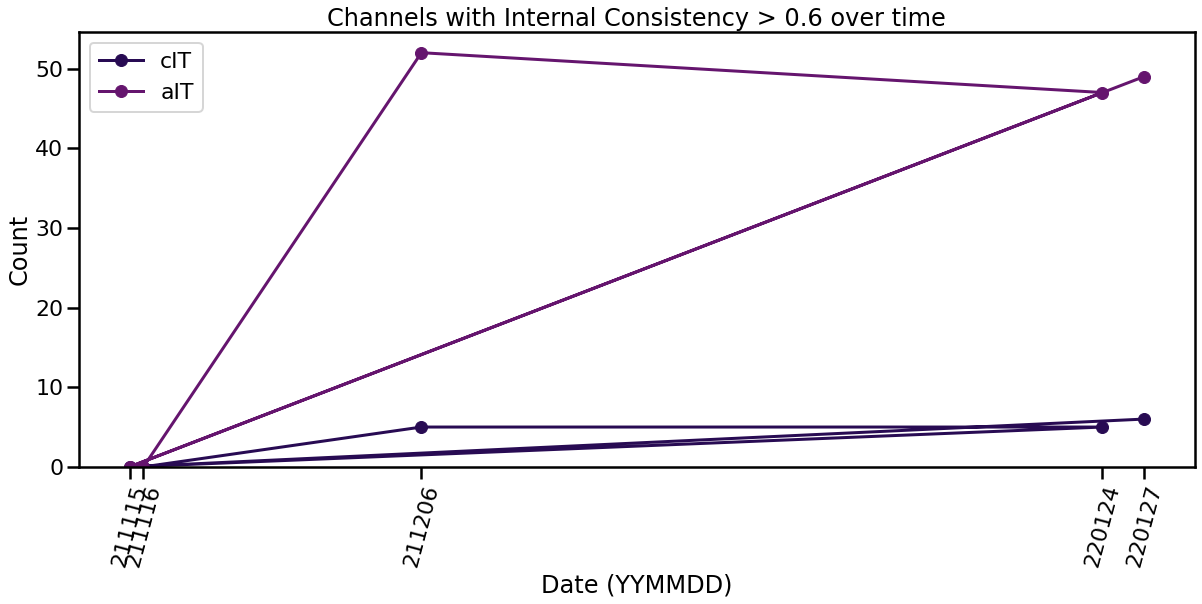

In [37]:
sns.set_context('poster')
sns.set_palette('inferno') 
fig = plt.figure(figsize = [20,8] )
plt.plot(mpd.datestr2num(['20'+i for i in  cIT_count.keys()]), cIT_count.values(), 'o-', label='cIT')
plt.plot(mpd.datestr2num(['20'+i for i in  cIT_count.keys()]), aIT_count.values(), 'o-', label='aIT')
# plt.xticks([int(i) for i in cIT_count.keys()], rotation = 75) 
plt.gca().set_ylim(bottom=0)
plt.xticks(mpd.datestr2num(['20'+i for i in  cIT_count.keys()]),cIT_count.keys(), rotation = 75)
locator = mpd.AutoDateLocator(interval_multiples=False)
# ax.xaxis.set_major_locator(locator)

plt.xlabel('Date (YYMMDD)')
plt.ylabel('Count')
plt.title('Channels with Internal Consistency > 0.6 over time')
plt.legend()

# plt.savefig('Figures/consistent_channels_over_time.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

In [38]:
all_cITs = []
all_aITs = []
cIT_channel_ids = {}
aIT_channel_ids = {}
for date in filtered_assembly_by_date:
    norm_assembly = filtered_assembly_by_date[date]
    cIT_channel_ids[date] = norm_assembly.neuroid_id.values[norm_assembly.subregion.values == 'cIT']
    aIT_channel_ids[date] = norm_assembly.neuroid_id.values[norm_assembly.subregion.values == 'aIT']
    all_cITs += list(norm_assembly.neuroid_id.values[norm_assembly.subregion.values == 'cIT'])
    all_aITs += list(norm_assembly.neuroid_id.values[norm_assembly.subregion.values == 'aIT'])
    

# all_cITs = np.unique(all_cITs )
# all_aITs = np.unique(all_aITs )    


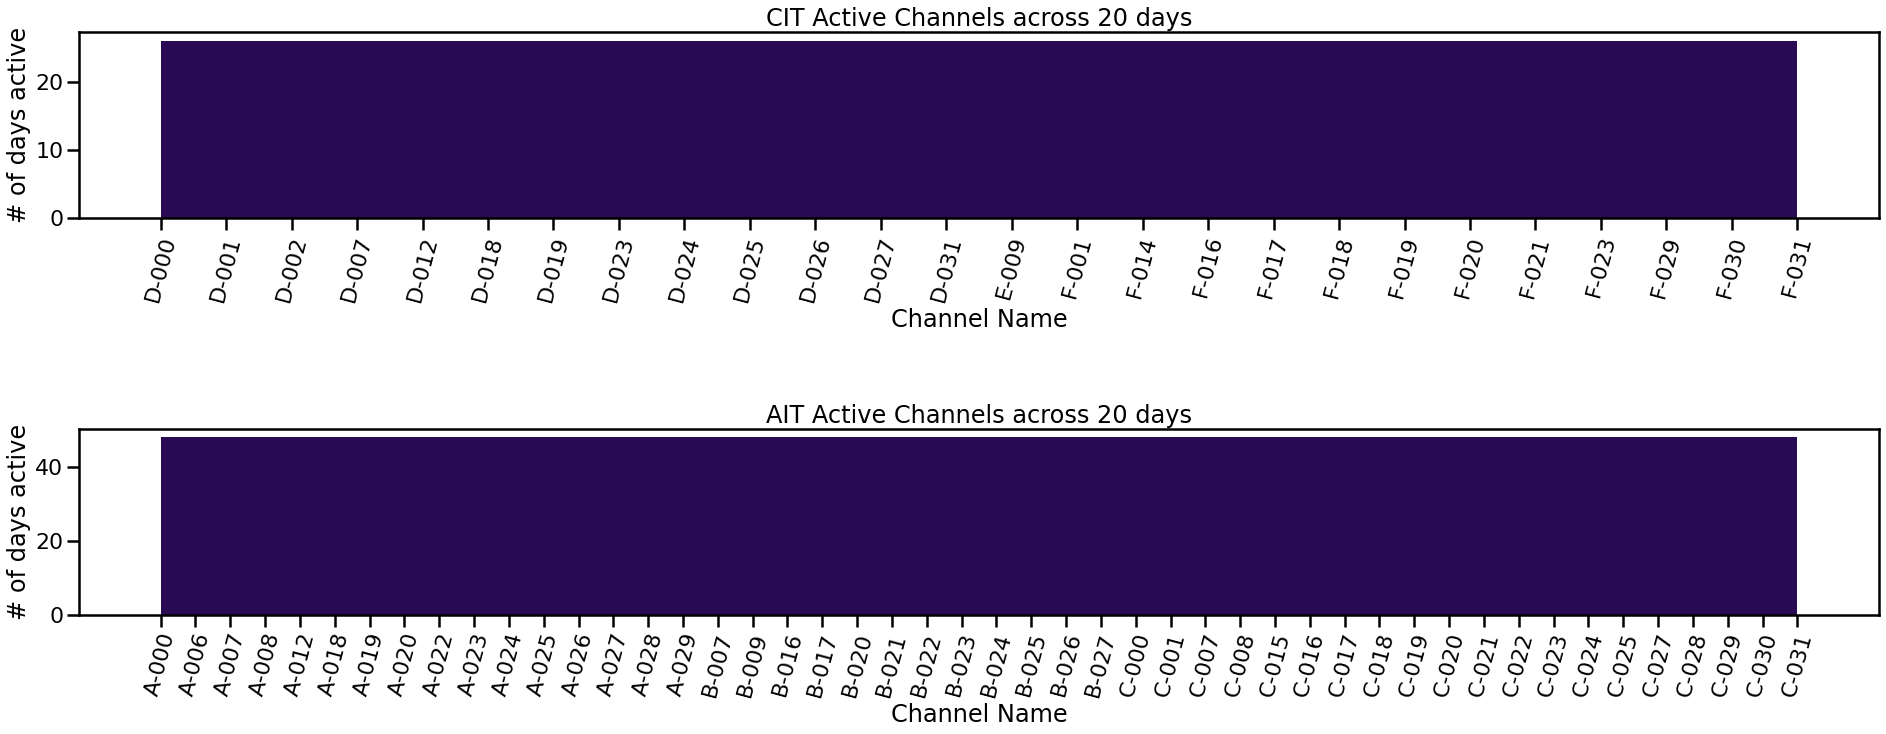

In [16]:
fig = plt.figure(figsize=[28,12])
sns.set_context('poster')
plt.subplot(2,1,1)
plt.hist(np.sort(all_cITs), 'stone')
plt.xticks(rotation=75);
plt.title('CIT Active Channels across 20 days')
plt.xlabel('Channel Name')
plt.ylabel('# of days active')

plt.subplot(2,1,2)
plt.hist(np.sort(all_aITs), 'stone')
plt.xticks(rotation=75);
plt.title('AIT Active Channels across 20 days')

plt.xlabel('Channel Name')
plt.ylabel('# of days active')

fig.tight_layout(pad=3.0)

# plt.savefig('active_channel_histogram.png', bbox_inches='tight')

# all_aITs

## Overall_Correlation

In [11]:
filtered_assembly_by_date = {}

date = '211206'
for date in [date]:
    if date in filtered_assembly_by_date.keys():
#         continue
        pass
    directory_path = os.path.join(procDataPath,[i for i in os.listdir(procDataPath) if date in i][0])

    filenames = [os.path.join(directory_path, i) for i in os.listdir(directory_path) if date in i]


    
    analysis_condition = '_'+analysis_conditions[cond_num]
    timebin_size = timebin_sizes[analysis_conditions[cond_num]]
    filename = [i for i in filenames if analysis_condition in i][0]
    print(filename)

    data = sio.loadmat(filename)


    psth = np.asarray(data['psth'])
    meta = data['meta']

    psth = psth[:-1, :, :, :]  # Remove responses to gray image (last image)

    timebase = np.arange(meta['start_time_ms'], meta['stop_time_ms'], meta['tb_ms'])
    t_cols = np.where((timebase >= 70) & (timebase < 170))[0]
    rate = psth[:, :, t_cols, :]
    time_ms = np.arange(meta['start_time_ms'][0][0][0][0], meta['stop_time_ms'][0][0][0][0], meta['tb_ms'][0][0][0][0])[t_cols]

    data_assembly = xr.DataArray(rate,
                                           coords={'repetition': ('repetition', list(range(rate.shape[1]))),
                                                   'image_id': ('image', list(range(rate.shape[0]))),
                                                   'time_ms': ('time_ms', list(time_ms)),
                                                   'id': ('image', list(range(rate.shape[0])))},
                                           dims=['image', 'repetition', 'time_ms','neuroid'])

    for column_name, column_data in neuroid_meta.iteritems():
        data_assembly = data_assembly.assign_coords(**{f'{column_name}': ('neuroid', list(column_data.values[:psth.shape[-1]]))})
    data_assembly = data_assembly.stack(presentation=('image', 'repetition')).reset_index('presentation')
    data_assembly = data_assembly.drop('image')
    data_assembly = data_assembly.transpose('presentation', 'neuroid', 'time_ms')
    data_assembly = NeuronRecordingAssembly(data_assembly)
    
    rate = np.mean(rate, axis=2)
    
    normalizer_assembly = xr.DataArray(rate,
                                           coords={'repetition': ('repetition', list(range(rate.shape[1]))),
                                                   'image_id': ('image', list(range(rate.shape[0]))),
                                                   'id': ('image', list(range(rate.shape[0])))},
                                           dims=['image', 'repetition','neuroid'])

    for column_name, column_data in neuroid_meta.iteritems():
        normalizer_assembly = normalizer_assembly.assign_coords(**{f'{column_name}': ('neuroid', list(column_data.values[:psth.shape[-1]]))})
    normalizer_assembly = normalizer_assembly.stack(presentation=('image', 'repetition')).reset_index('presentation')
    normalizer_assembly = normalizer_assembly.drop('image')
    normalizer_assembly = normalizer_assembly.transpose('presentation', 'neuroid')
    normalizer_assembly = NeuronRecordingAssembly(normalizer_assembly)
    try:
        filtered_assembly = filter_neuroids(normalizer_assembly, 0.6) 
        filtered_assembly_by_date[date] = filtered_assembly
    except:
        continue
        
        
# joblib.dump(filtered_assembly_by_date, 'filtered_assembly_by_date.pkl')

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

/braintree/data2/active/users/ssazaidi/projects/normalizers-pIT/monkeys/oleo/intanproc/oleo_normalizers-pIT_211206_121917/oleo_normalizers-pIT_211206_121917_psth_base.mat


cross-validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [12]:
it_assembly = data_assembly.sel(neuroid=np.isin(data_assembly.neuroid_id, filtered_assembly.neuroid_id))

In [118]:
## it_assembly = filtered_assembly_by_date[date]
cit_assembly = it_assembly[:,it_assembly.subregion == 'cIT']
ait_assembly = it_assembly[:,it_assembly.subregion == 'aIT']


cit_assembly.values = np.nan_to_num(cit_assembly.values)
ait_assembly.values = np.nan_to_num(ait_assembly.values)

cov_ait_cit = ait_assembly.values.T@cit_assembly.values
fig = plt.figure(figsize=[20,5])
  
plt.imshow(cov_ait_cit, cmap='inferno')
plt.colorbar()



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 26 is different from 1300)

In [132]:
out = cit_assembly[:,0].values.T@cit_assembly[:,0].values

In [137]:
cit_assembly[:,0].values.shape

(1300, 10)

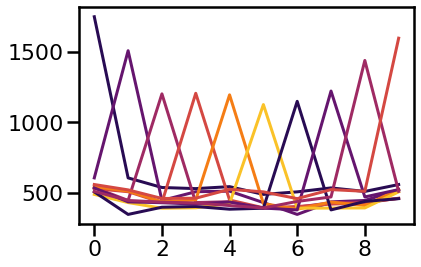

In [133]:
plt.plot(out.T)

In [122]:
cit_assembly.shape, ait_assembly.shape

((1300, 26, 10), (1300, 48, 10))

In [165]:
max_corrs = np.zeros([cit_assembly.shape[1], ait_assembly.shape[1]])
lag_corrs = np.zeros_like(max_corrs)

In [167]:

for c in range(cit_assembly.shape[1]):
    for a in range(ait_assembly.shape[1]):

        sig = cit_assembly[:,c].values.T
        sig_noise = ait_assembly[:,a].values.T
        corr = signal.correlate(sig, sig_noise, mode='same')
        lags = signal.correlation_lags(len(sig), len(sig_noise), mode='same')

        corr = np.mean(corr.T, axis=0)
        # corr /= np.max(corr)
    #     print()
        max_corrs[c,a] = np.max(corr)
        lag_corrs[c,a] = lags[np.argmax(corr)]

    #     fig, (ax_corr) = plt.subplots(1, 1, figsize=(4.8, 4.8))
    #     # ax_orig.plot(sig)
    #     # ax_orig.set_title('Original signal')
    #     # ax_orig.set_xlabel('Sample Number')
    #     # ax_noise.plot(sig_noise)
    #     # ax_noise.set_title('Signal with noise')
    #     # ax_noise.set_xlabel('Sample Number')
    #     ax_corr.plot(lags, corr)
    #     ax_corr.set_title('Cross-correlated signal')
    #     ax_corr.set_xlabel('Lag')
    #     ax_orig.margins(0, 0.1)
    #     ax_noise.margins(0, 0.1)
    #     ax_corr.margins(0, 0.1)
    #     fig.tight_layout()
    #     plt.show()

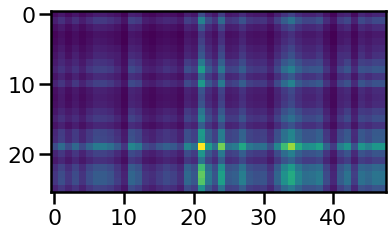

In [168]:
plt.imshow(max_corrs)